In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [2]:
import numpy as np
import pandas as pd
import umap
from sklearn.datasets import make_classification

np.random.seed(seed=42) 

In [3]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


param_grid = [
    {"dual":[False],"max_iter":[10000000], "penalty":["l1","l2"], "tol":[1e-4], "C":[1,10]},
    { "max_iter":[10000000], "loss":["squared_hinge", "hinge"], "tol":[1e-4], "C":[1,10,30]}
]

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, 'dual': False, 'max_iter': 10000000, 'penalty': 'l2', 'tol': 0.0001}))
])

def runSVM(X,y, X_valid,y_valid):
    
    clf_grid = Pipeline([
        ("scaler", StandardScaler()),
        ("SVMGrid",GridSearchCV(LinearSVC(), param_grid, cv=10, iid=False, scoring="neg_mean_squared_error", n_jobs=2))
    ])
    
    clf_grid.fit(X, y)
    grid = clf_grid.steps[1][1]
    print(grid.best_params_)

    svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("SVM", LinearSVC(**grid.best_params_))
    ])
    
    svm_clf.fit(X, y)
    print("SVM Test Accuracy: {:0.3f}".format(svm_clf.score(X_valid, y_valid)))

    _score = cross_val_score(svm_clf, X=X, y=y, cv=10)
    print("SVM CV Accuracy: {:0.3f}(+/- {:.3f})".format(_score.mean(), _score.std()*2))
    
    return svm_clf, grid.best_params_

In [228]:
# X,y = make_classification(n_samples=3000, n_classes=3, weights=[0.25,0.25,0.5], n_informative=5, class_sep=0.8, n_clusters_per_class=1, hypercube=False, random_state=42)
X,y = make_classification(n_samples=3000, n_classes=3, n_informative=3, class_sep=1, n_clusters_per_class=1, hypercube=False, shuffle=False, random_state=42)
X.shape

(3000, 20)

In [229]:
X[:,:3].shape

(3000, 3)

In [230]:
# reducer = umap.UMAP(random_state=42,
#                     n_components = 3,
#                     n_neighbors=50,
#                     min_dist=0)
# embedding = reducer.fit_transform(X)

embedding=X[:, :3]

In [232]:
emb3d = go.Scatter3d(
    x=embedding[:,0],
    y=embedding[:,1],
    z=embedding[:,2],
    mode="markers",
    name="Training",
    marker=dict(
        size=2,
        color=y,
        colorscale="Viridis",
        showscale=True,
        opacity=0.8
    ),
    text=y
)

layout = go.Layout(
    title="3D LRP Embedding",
    autosize=False,
    width=1200,
    height=1000,
    paper_bgcolor='#F5F5F5'
)


pltdata=[emb3d]

fig = go.Figure(data=pltdata, layout=layout)
iplot(fig, filename='lrp-3d-heart.html')

In [233]:
from helper import split_valid, plot_confusion_matrix
from sklearn.metrics import classification_report

data = pd.DataFrame(X[:,:3])
labels = pd.Series(y)

X_train, y_train, X_valid, y_valid = split_valid(data, labels, valid_size=0.5)

In [234]:
y_valid.value_counts()

2    503
1    499
0    498
dtype: int64

In [235]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 7.69 ms, sys: 801 µs, total: 8.49 ms
Wall time: 7.91 ms
SVM Test Accuracy: 0.858


In [236]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)
original_svm = clf

In [237]:
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","B","C"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.85      0.73      0.78       498
           B       0.82      0.91      0.86       499
           C       0.90      0.93      0.92       503

    accuracy                           0.86      1500
   macro avg       0.86      0.86      0.86      1500
weighted avg       0.86      0.86      0.86      1500



Confusion matrix, without normalization
[[0.72891566 0.18273092 0.08835341]
 [0.07815631 0.90981964 0.01202405]
 [0.05168986 0.0139165  0.93439364]]
Overall Accuracy: 0.8580


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2f70e438>,
 array([[363,  91,  44],
        [ 39, 454,   6],
        [ 26,   7, 470]]))

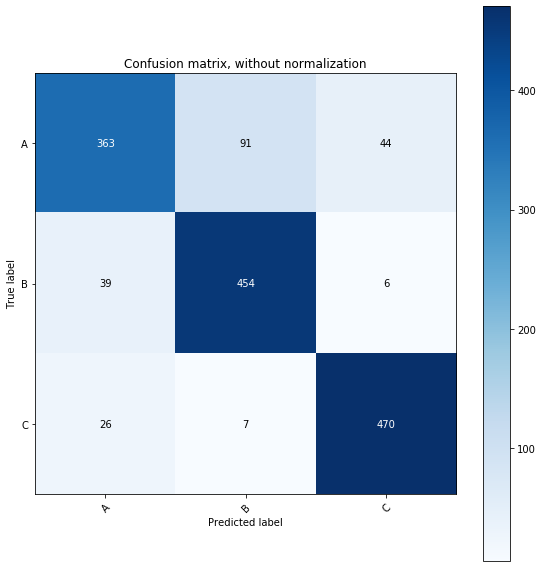

In [239]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)

# Looking at subclusters separated

In [240]:
from sklearn.utils.multiclass import unique_labels

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("SVM",LinearSVC(**{'C': 1, 'max_iter': 10000000, 'loss': 'hinge', 'tol': 0.0001}))
])

def runSVMAnalysis(skip_class, classes=np.array(["A","B","C"])):
    
    bi_train = X_train[y_train != skip_class]
    bi_y_train = y_train[y_train != skip_class]

    bi_valid = X_valid[y_valid != skip_class]
    bi_y_valid = y_valid[y_valid != skip_class]
    
    %time clf.fit(bi_train, bi_y_train)
    print("SVM Test Accuracy: {:0.3f}".format(clf.score(bi_valid, bi_y_valid)))

    bi_svm, bi_best_params = runSVM(bi_train, bi_y_train, bi_valid, bi_y_valid)
#     bi_svm = clf
    
    y_pred =  bi_svm.predict(bi_valid)
    correct_ = bi_y_valid[y_pred == bi_y_valid]

    # Only use the labels that appear in the data
    print(unique_labels(bi_y_valid, y_pred))
    target_names = classes[unique_labels(bi_y_valid, y_pred)]
    print(classification_report(bi_y_valid.values, y_pred, target_names=target_names))

    plot_confusion_matrix(bi_y_valid.values, y_pred.astype(int), classes)
    
    return correct_

## A vs B

CPU times: user 4.23 ms, sys: 597 µs, total: 4.83 ms
Wall time: 4.39 ms
SVM Test Accuracy: 0.887
{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.887
SVM CV Accuracy: 0.886(+/- 0.046)
[0 1]
              precision    recall  f1-score   support

           A       0.87      0.91      0.89       498
           B       0.90      0.87      0.88       499

    accuracy                           0.89       997
   macro avg       0.89      0.89      0.89       997
weighted avg       0.89      0.89      0.89       997

Confusion matrix, without normalization
[[0.90562249 0.09437751]
 [0.13226453 0.86773547]]
Overall Accuracy: 0.8867


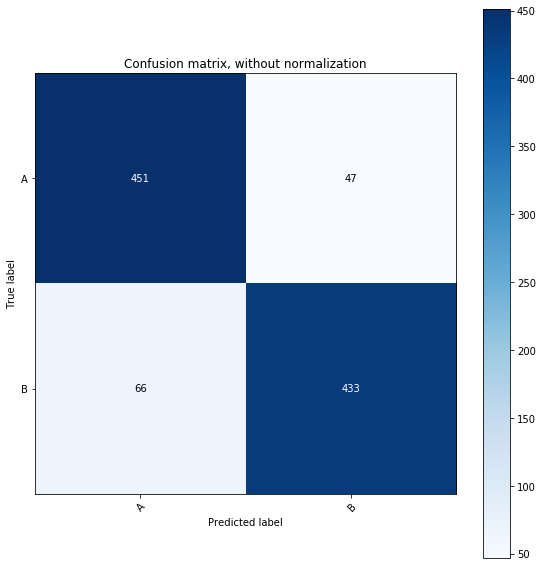

In [241]:
correct_AB = runSVMAnalysis(skip_class=2)

## B vs C

CPU times: user 4.08 ms, sys: 312 µs, total: 4.39 ms
Wall time: 4.37 ms
SVM Test Accuracy: 0.977
{'C': 1, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.977
SVM CV Accuracy: 0.961(+/- 0.031)
[1 2]
              precision    recall  f1-score   support

           B       0.98      0.98      0.98       499
           C       0.98      0.98      0.98       503

    accuracy                           0.98      1002
   macro avg       0.98      0.98      0.98      1002
weighted avg       0.98      0.98      0.98      1002

Confusion matrix, without normalization
[[0.97795591 0.02204409]
 [0.02385686 0.97614314]]
Overall Accuracy: 0.9770


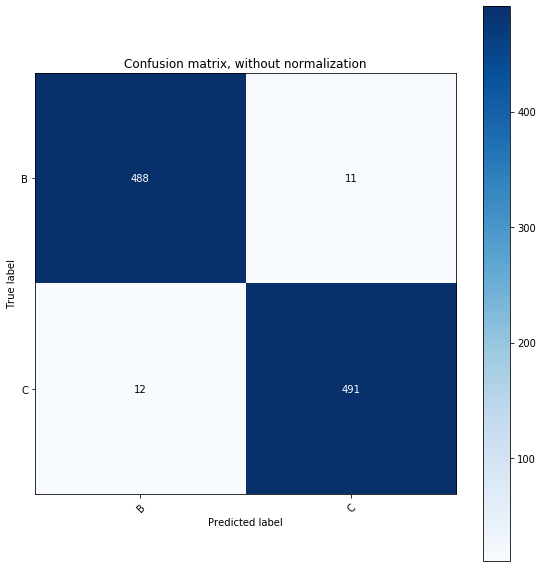

In [243]:
correct_BC = runSVMAnalysis(skip_class=0)

## A vs C

CPU times: user 4.11 ms, sys: 363 µs, total: 4.47 ms
Wall time: 4.18 ms
SVM Test Accuracy: 0.938
{'C': 10, 'loss': 'hinge', 'max_iter': 10000000, 'tol': 0.0001}
SVM Test Accuracy: 0.938
SVM CV Accuracy: 0.911(+/- 0.068)
[0 2]
              precision    recall  f1-score   support

           A       0.92      0.96      0.94       498
           C       0.96      0.92      0.94       503

    accuracy                           0.94      1001
   macro avg       0.94      0.94      0.94      1001
weighted avg       0.94      0.94      0.94      1001

Confusion matrix, without normalization
[[0.95983936 0.04016064]
 [0.08349901 0.91650099]]
Overall Accuracy: 0.9381


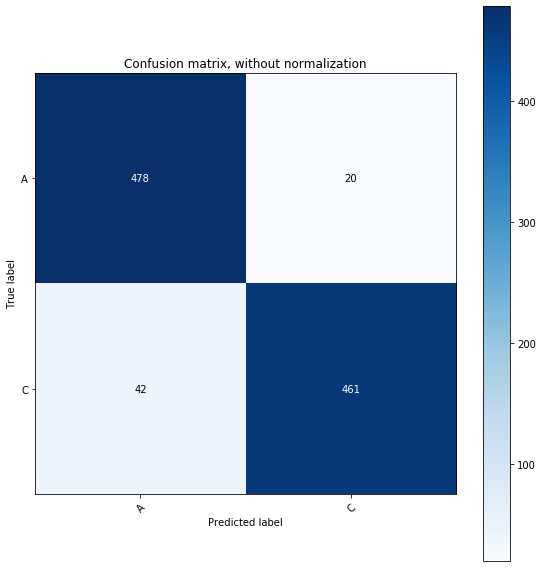

In [242]:
correct_AC = runSVMAnalysis(skip_class=1)

## Looking at final per-class accuracies

In [244]:
y_valid.value_counts()

2    503
1    499
0    498
dtype: int64

In [245]:
A_idxs_1 = set(correct_AC[correct_AC == 0].index)
A_idxs_2 = set(correct_AB[correct_AB == 0].index)

A_total = A_idxs_1.union(A_idxs_2)
print("Number of A samples predicted:", len(A_total))
print("Ratio:", len(A_total)/y_valid.value_counts()[0])

Number of A samples predicted: 498
Ratio: 1.0


In [246]:
B_idxs_1 = set(correct_BC[correct_BC == 1].index)
B_idxs_2 = set(correct_AB[correct_AB == 1].index)

B_total = B_idxs_1.union(B_idxs_2)
print("Number of B samples predicted:", len(B_total))
print("Ratio:", len(B_total)/y_valid.value_counts()[1])

Number of B samples predicted: 488
Ratio: 0.9779559118236473


In [247]:
# B_total - B_idxs_1

In [248]:
C_idxs_1 = set(correct_BC[correct_BC == 2].index)
C_idxs_2 = set(correct_AC[correct_AC == 2].index)

C_total = C_idxs_1.union(C_idxs_2)
print("Number of C samples predicted:", len(C_total))
print("Ratio:", len(C_total)/y_valid.value_counts()[2])

Number of C samples predicted: 491
Ratio: 0.9761431411530815


In [60]:
# C_total - C_idxs_2

{209, 920, 1514, 1956, 2462}

## By looking at these observations, we have evidence that the dataset will perform well for our analysis
## The initial binary classification should be (A v B) vs C
## The results above show us that A vs C and B vs C should both perform better

In [251]:
labels.value_counts().min()

995

In [258]:
new_data = pd.DataFrame(columns=data.columns)
new_labels = pd.Series()

skip_class = 0
class_size = labels.value_counts() #[skip_class]

# for labl in range(3):
#     _labels = labels[ labels == labl]
    
#     size = class_size #//2
# #     if labl == skip_class: size *=2 # To balance final binary classes 
    
#     rand_selected = _labels.sample(n=size, replace=False, random_state=42).index
#     _data = data.reindex(rand_selected)
#     _labels = _labels.reindex(rand_selected)
    
#     new_data = new_data.append(_data)
#     new_labels = new_labels.append(_labels)


new_data = data.copy()
new_labels = labels.copy()

new_labels[new_labels == skip_class] = -1

new_labels[new_labels != -1] = 1

# skip_class is now control
new_labels[new_labels == -1] = 0

print(new_data.shape)
new_data.head()

(3000, 3)


,0,1,2
0,-1.771096,-0.880628,0.798117
1,-1.801742,-1.303633,1.506837
2,-0.748782,-1.233078,0.565521
3,0.968113,-2.081145,-0.776763
4,0.224540,-0.837789,0.273681


In [259]:
new_labels.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [260]:
X_train, y_train, X_valid, y_valid = split_valid(new_data, new_labels, valid_size=0.5)
X_train.index

Int64Index([2880,   45, 1090, 2121, 2039,  184, 1920,  698, 1494, 1671,
            ...
            1393, 1458,  461,  524, 1507, 2995,  528, 2461, 2761, 2677],
           dtype='int64', length=1500)

In [261]:
%time clf.fit(X_train, y_train)
print("SVM Test Accuracy: {:0.3f}".format(clf.score(X_valid, y_valid)))

CPU times: user 6.29 ms, sys: 561 µs, total: 6.85 ms
Wall time: 6.36 ms
SVM Test Accuracy: 0.832


In [262]:
# original_svm, orig_best_params = runSVM(X_train, y_train, X_valid, y_valid)

In [264]:
original_svm = clf
y_pred = original_svm.predict(X_valid)
target_names = np.array(["A","BC"])
print(classification_report(y_valid.values, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           A       0.85      0.60      0.70       498
          BC       0.83      0.95      0.88      1002

    accuracy                           0.83      1500
   macro avg       0.84      0.77      0.79      1500
weighted avg       0.83      0.83      0.82      1500



Confusion matrix, without normalization
[[0.59839357 0.40160643]
 [0.05189621 0.94810379]]
Overall Accuracy: 0.8320


(<matplotlib.axes._subplots.AxesSubplot at 0x1a2da118d0>, array([[298, 200],
        [ 52, 950]]))

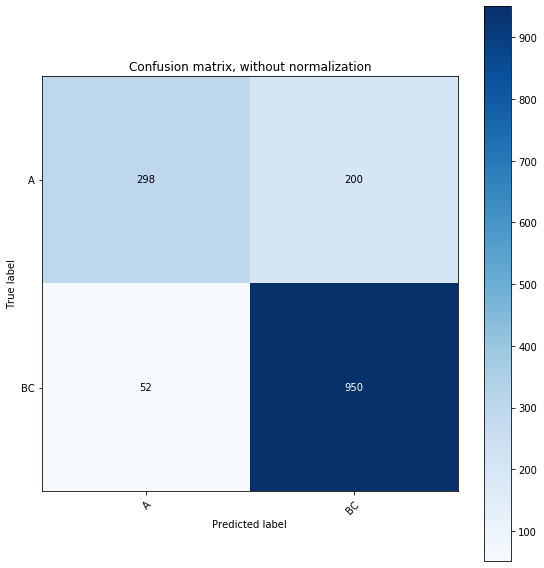

In [265]:
plot_confusion_matrix(y_valid.values, y_pred.astype(int), target_names)